19.1 Домашнее задание GAN и Style Transfer

Neural Style Transfer (NST)

Alex_K_271341984

### 0. Baseline на основе семинарского ноутбука

Импортируем нужные библиотеки

In [1]:
%matplotlib inline
from PIL import Image

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
!ls images

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [3]:
!dir images

 ’®¬ ў гбва®©бвўҐ C ­Ґ Ё¬ҐҐв ¬ҐвЄЁ.
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : BCAE-8191

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ C:\Users\User\PycharmProjects\19.1 „®¬ и­ҐҐ § ¤ ­ЁҐ GAN Ё Style Transfer\images

11.01.2021  16:05    <DIR>          .
11.01.2021  16:05    <DIR>          ..
25.09.2020  23:36           385я938 earth.jpg
07.01.2021  00:28           701я762 matisse.jpg
07.01.2021  00:24           317я655 matisse_picasso.jpg
15.04.2019  17:15           644я851 minecraft.jpg
03.08.2020  00:54           853я892 mona_lisa.jpg
07.01.2021  00:36           393я606 monet.jpg
08.01.2021  18:28           162я722 monet_0.jpg
14.02.2017  00:57            91я888 picasso.jpg
08.01.2021  17:02            31я392 picasso_0.jpg
11.01.2021  11:12           162я832 shagal_cns.jpg
29.12.2020  00:44           106я898 wave.jpg
              11 д ©«®ў      3я853я436 Ў ©в
               2 Ї Ї®Є  103я803я494я400 Ў ©в бў®Ў®¤­®


In [4]:
imsize = 512  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [7]:
style_img = image_loader("images/wave.jpg") # as well as here
#content_img = image_loader("images/mona_lisa.jpg") #измените путь на тот который у вас.
content_img = image_loader("images/earth.jpg")

Посмотрим на исходные картинки.

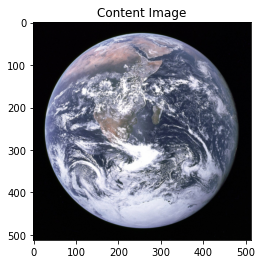

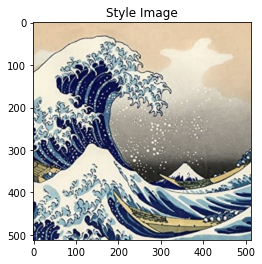

In [8]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    # функция для отрисовки изображения
    image = tensor.cpu().clone()   
    image = image.squeeze(0)     
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    #plt.pause(0.001) 

def imsave(tensor, name):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = transforms.ToPILImage(image)
    plt.axis('off')
    plt.title(None)
    plt.savefig(name, dpi=150, bbox_inches='tight', pad_inches=0)
    plt.show()
    
# отрисовка
plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(style_img, title='Style Image')

In [9]:
# создадим функцию для отрисовки промежуточных и конечных результатов
def plot_results():
    if (not 'output' in vars()) or (output is None): output = content_img
        
    fig = plt.figure(figsize=(15, 15))

    fig.add_subplot(1, 3, 1)
    imshow(content_img, title='Content Image')

    fig.add_subplot(1, 3, 2)
    imshow(style_img, title='Style Image')

    fig.add_subplot(1, 3, 3)
    imshow(output, title='Output Image')

    plt.show()

In [10]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

Функция для матрицы Грама

In [11]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

In [12]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.

In [13]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [14]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

In [15]:
content_layers_default = ['conv_2', 'conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [16]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [17]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [18]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()])
        #optimizer = optim.Adam([input_img.requires_grad_()]) 
        return optimizer

In [19]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()
                    #plot_results()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

In [20]:
input_img = content_img.clone()

# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)


Проведём обучение.

In [21]:
# обучение
output = None
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..


<ipython-input-14-990918138254>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-990918138254>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]:
Style Loss : 9.932953 Content Loss: 13.318233

run [100]:
Style Loss : 5.694326 Content Loss: 11.976999

run [150]:
Style Loss : 4.283921 Content Loss: 12.443762

run [200]:
Style Loss : 3.314045 Content Loss: 13.406740

run [250]:
Style Loss : 5.826020 Content Loss: 16.548164

run [300]:
Style Loss : 2772898.000000 Content Loss: 584.952515

run [350]:
Style Loss : 60.316238 Content Loss: 42.353226

run [400]:
Style Loss : 6.840340 Content Loss: 29.624277

run [450]:
Style Loss : 3.052000 Content Loss: 21.393257

run [500]:
Style Loss : 1.970389 Content Loss: 17.218979



Посмотрим на результат.

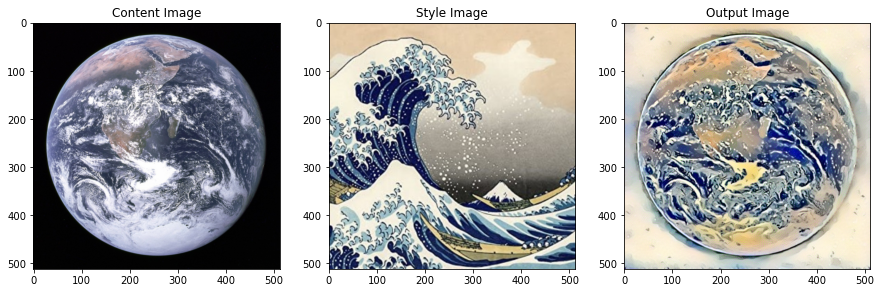

In [22]:
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 3, 1)
imshow(content_img, title='Content Image')

fig.add_subplot(1, 3, 2)
imshow(style_img, title='Style Image')

fig.add_subplot(1, 3, 3)
imshow(output, title='Output Image')

plt.show()

Результат прекрасен. Попробуем на других картинках.

In [23]:
style_img = image_loader("images/shagal_cns.jpg") 

content_img = image_loader("images/mona_lisa.jpg")

input_img = content_img.clone()

In [24]:
output = None
tic = time.time()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
toc = time.time()

Building the style transfer model..
Optimizing..


<ipython-input-14-990918138254>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-990918138254>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 24.796362 Content Loss: 15.062759

run [100]:
Style Loss : 3.735124 Content Loss: 12.872948

run [150]:
Style Loss : 1.146531 Content Loss: 11.201097

run [200]:
Style Loss : 0.709878 Content Loss: 10.576035

run [250]:
Style Loss : 0.568404 Content Loss: 10.278307

run [300]:
Style Loss : 0.511384 Content Loss: 10.113358

run [350]:
Style Loss : 0.491746 Content Loss: 10.013105

run [400]:
Style Loss : 0.486182 Content Loss: 9.953413

run [450]:
Style Loss : 0.487104 Content Loss: 9.912158

run [500]:
Style Loss : 0.488020 Content Loss: 9.885260



In [25]:
print(f'Время обучения {toc-tic} секунд.')

Время обучения 203.11266136169434 секунд.


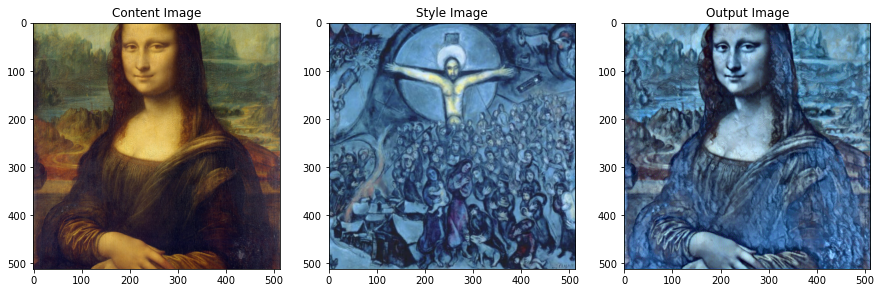

In [26]:
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 3, 1)
imshow(content_img, title='Content Image')

fig.add_subplot(1, 3, 2)
imshow(style_img, title='Style Image')

fig.add_subplot(1, 3, 3)
imshow(output, title='Output Image')

plt.show()

Результат так себе. Попробуем ещё на других картинках.

In [27]:
style_img = image_loader("images/shagal_cns.jpg") 

content_img = image_loader("images/minecraft.jpg")

input_img = content_img.clone()

In [28]:
output = None
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..
Optimizing..


<ipython-input-14-990918138254>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-990918138254>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 27.396824 Content Loss: 18.535719

run [100]:
Style Loss : 4.071067 Content Loss: 14.746101

run [150]:
Style Loss : 1.753909 Content Loss: 13.021011

run [200]:
Style Loss : 1.302922 Content Loss: 12.324848

run [250]:
Style Loss : 1.125010 Content Loss: 11.996326

run [300]:
Style Loss : 1.019164 Content Loss: 11.842300

run [350]:
Style Loss : 0.990712 Content Loss: 11.766441

run [400]:
Style Loss : 1.011925 Content Loss: 11.789289

run [450]:
Style Loss : 1.022052 Content Loss: 11.805836

run [500]:
Style Loss : 1.248232 Content Loss: 11.998873



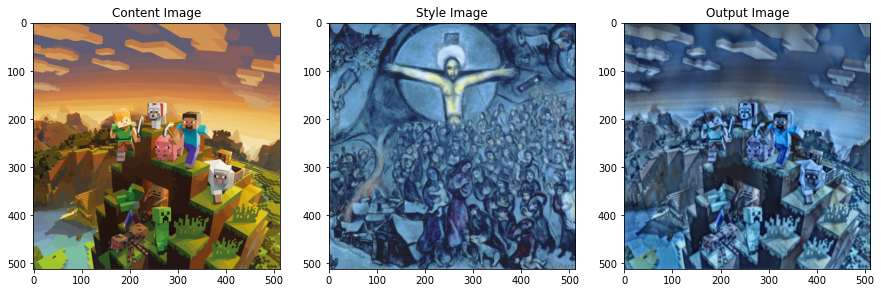

In [29]:
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 3, 1)
imshow(content_img, title='Content Image')

fig.add_subplot(1, 3, 2)
imshow(style_img, title='Style Image')

fig.add_subplot(1, 3, 3)
imshow(output, title='Output Image')

plt.show()

Красота!

### 1. Вы переносите одновременно два стиля на одну картинку контента.

#### 1.0. Решение "хитрое"

Применим два стиля на следующим образом: создадим новую картинку стиля, которая состоит из двух картинок стилей, которые нужно применить.

In [30]:
style_img_1 = image_loader("images/picasso.jpg")
style_img_2 = image_loader("images/matisse.jpg")
style_img_12 = image_loader("images/matisse_picasso.jpg")

content_img = image_loader("images/mona_lisa.jpg") 

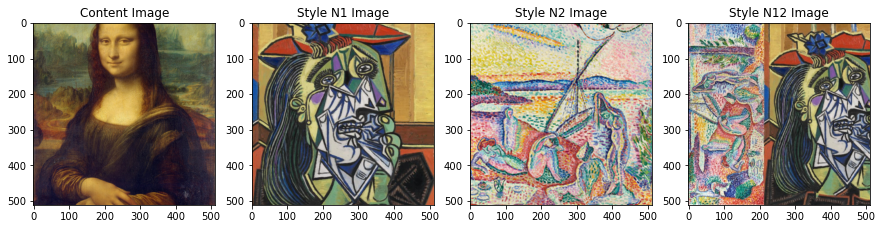

In [31]:
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 4, 1)
imshow(content_img, title='Content Image')

fig.add_subplot(1, 4, 2)
imshow(style_img_1, title='Style N1 Image')

fig.add_subplot(1, 4, 3)
imshow(style_img_2, title='Style N2 Image')

fig.add_subplot(1, 4, 4)
imshow(style_img_12, title='Style N12 Image')

Сначала отдельно применим первый стиль.

In [32]:
input_img = content_img.clone()
output_st1 = None
output_st1 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img_1, input_img)

Building the style transfer model..
Optimizing..


<ipython-input-14-990918138254>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-990918138254>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 10.124881 Content Loss: 16.767010

run [100]:
Style Loss : 2.925517 Content Loss: 14.722435

run [150]:
Style Loss : 1.550222 Content Loss: 13.604143

run [200]:
Style Loss : 1.173206 Content Loss: 13.074802

run [250]:
Style Loss : 1.023845 Content Loss: 12.794258

run [300]:
Style Loss : 0.957501 Content Loss: 12.628645

run [350]:
Style Loss : 0.920886 Content Loss: 12.536133

run [400]:
Style Loss : 0.901820 Content Loss: 12.475025

run [450]:
Style Loss : 0.888299 Content Loss: 12.430483

run [500]:
Style Loss : 0.877902 Content Loss: 12.404980



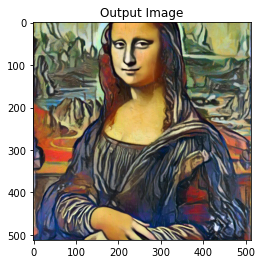

In [33]:
plt.figure()
imshow(output_st1, title='Output Image')
plt.ioff()
plt.show()

Теперь отдельно второй стиль.

In [34]:
input_img = content_img.clone()
output_st2 = None
output_st2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img_2, input_img)

Building the style transfer model..
Optimizing..


<ipython-input-14-990918138254>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-990918138254>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 37.292736 Content Loss: 43.134144

run [100]:
Style Loss : 14.719882 Content Loss: 39.260098

run [150]:
Style Loss : 9.255728 Content Loss: 35.400085

run [200]:
Style Loss : 6.269050 Content Loss: 33.099468

run [250]:
Style Loss : 4.369987 Content Loss: 31.693378

run [300]:
Style Loss : 2.938684 Content Loss: 30.700603

run [350]:
Style Loss : 2.110260 Content Loss: 30.155302

run [400]:
Style Loss : 1.580192 Content Loss: 29.712973

run [450]:
Style Loss : 1.305193 Content Loss: 29.408901

run [500]:
Style Loss : 1.178979 Content Loss: 29.142662



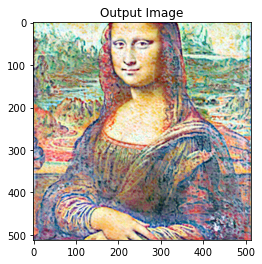

In [35]:
plt.figure()
imshow(output_st2, title='Output Image')
plt.ioff()
plt.show()

А теперь "сразу два" стиля.

In [36]:
input_img = content_img.clone()
output_st12 = None
output_st12 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img_12, input_img)

Building the style transfer model..
Optimizing..


<ipython-input-14-990918138254>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-990918138254>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 16.658678 Content Loss: 25.647003

run [100]:
Style Loss : 4.270916 Content Loss: 22.503792

run [150]:
Style Loss : 2.178593 Content Loss: 20.277027

run [200]:
Style Loss : 1.444018 Content Loss: 19.191744

run [250]:
Style Loss : 1.128822 Content Loss: 18.580025

run [300]:
Style Loss : 1.006130 Content Loss: 18.201458

run [350]:
Style Loss : 0.945854 Content Loss: 17.978920

run [400]:
Style Loss : 0.918985 Content Loss: 17.852262

run [450]:
Style Loss : 0.916594 Content Loss: 17.782623

run [500]:
Style Loss : 0.976956 Content Loss: 17.706371



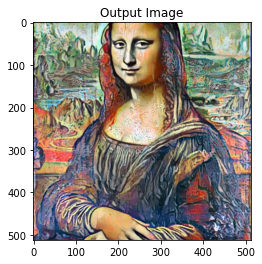

In [37]:
plt.figure()
imshow(output_st12, title='Output Image')
plt.ioff()
plt.show()

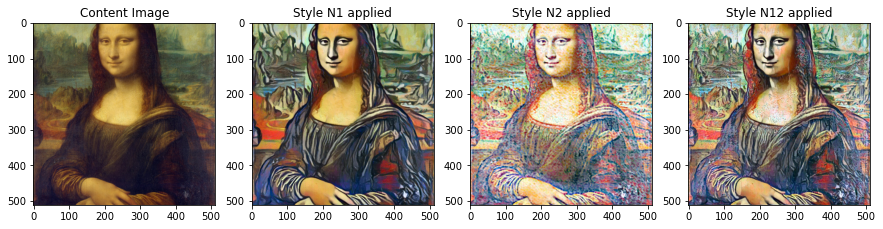

In [38]:
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 4, 1)
imshow(content_img, title='Content Image')

fig.add_subplot(1, 4, 2)
imshow(output_st1, title='Style N1 applied')

fig.add_subplot(1, 4, 3)
imshow(output_st2, title='Style N2 applied')

fig.add_subplot(1, 4, 4)
imshow(output_st12, title='Style N12 applied')

Силу стиля можно регулировать путём изменения площадил картинки дочернего стиля на картинке финального. :)

#### 1.1. Решение нормальное

Суть решения: для второго стиля добавим в слои со style loss. Для этого нужно переписать функции get_style_model_and_losses и run_style_transfer.

In [39]:
def get_style_model_and_losses_2s_st(cnn, normalization_mean, normalization_std,
                                   style_1_img, style_2_img, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_1_losses = []
        style_2_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style_1 loss:
                target_1_feature = model(style_1_img).detach()
                style_1_loss = StyleLoss(target_1_feature)
                model.add_module("style_1_loss_{}".format(i), style_1_loss)
                style_1_losses.append(style_1_loss)
                
                # add style_2 loss:
                target_2_feature = model(style_2_img).detach()
                style_2_loss = StyleLoss(target_2_feature)
                model.add_module("style_2_loss_{}".format(i), style_2_loss)
                style_2_losses.append(style_2_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) -1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_1_losses, style_2_losses, content_losses

In [40]:
def run_style_transfer_2s_st(cnn, normalization_mean, normalization_std,
                        content_img, style_1_img, style_2_img, input_img, num_steps=500,
                        style_1_weight=500000, style_2_weight=500000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_1_losses, style_2_losses, content_losses = get_style_model_and_losses_2s_st(cnn,
            normalization_mean, normalization_std, style_1_img, style_2_img, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_1_score = 0
                style_2_score = 0
                content_score = 0

                for sl in style_1_losses:
                    style_1_score += sl.loss
                for sl in style_2_losses:
                    style_2_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_1_score *= style_1_weight
                style_2_score *= style_2_weight
                content_score *= content_weight

                loss = style_1_score + style_2_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style 1 Loss : {:4f}, Style 2 Loss : {:4f}, Content Loss: {:4f}'.format(
                        style_1_score.item(), style_1_score.item(), content_score.item()))
                    print()

                return style_1_score + style_2_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Посмотрим, что было:

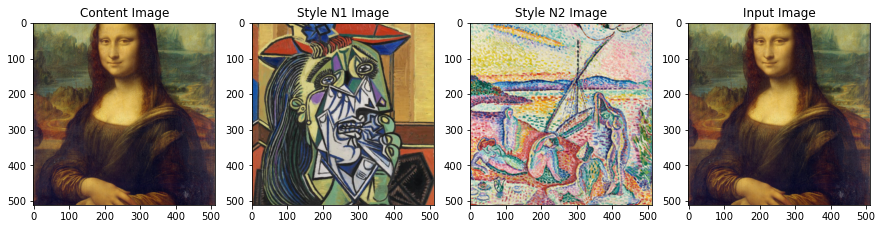

In [41]:
input_img = content_img.clone()

fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 4, 1)
imshow(content_img, title='Content Image')

fig.add_subplot(1, 4, 2)
imshow(style_img_1, title='Style N1 Image')

fig.add_subplot(1, 4, 3)
imshow(style_img_2, title='Style N2 Image')

fig.add_subplot(1, 4, 4)
imshow(input_img, title='Input Image')


In [42]:
output = None
tic = time.time()
output = run_style_transfer_2s_st(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img_1, style_img_2, input_img)
toc = time.time()

Building the style transfer model..
Optimizing..


<ipython-input-14-990918138254>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-990918138254>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style 1 Loss : 6191.384766, Style 2 Loss : 6191.384766, Content Loss: 45.617294

run [100]:
Style 1 Loss : 6015.813965, Style 2 Loss : 6015.813965, Content Loss: 44.575279

run [150]:
Style 1 Loss : 5998.133301, Style 2 Loss : 5998.133301, Content Loss: 42.172394

run [200]:
Style 1 Loss : 5998.463867, Style 2 Loss : 5998.463867, Content Loss: 39.387871

run [250]:
Style 1 Loss : 5998.870117, Style 2 Loss : 5998.870117, Content Loss: 36.584545

run [300]:
Style 1 Loss : 6001.155762, Style 2 Loss : 6001.155762, Content Loss: 34.026245

run [350]:
Style 1 Loss : 5998.893066, Style 2 Loss : 5998.893066, Content Loss: 32.007042

run [400]:
Style 1 Loss : 5999.198242, Style 2 Loss : 5999.198242, Content Loss: 30.135654

run [450]:
Style 1 Loss : 6001.863281, Style 2 Loss : 6001.863281, Content Loss: 28.942482

run [500]:
Style 1 Loss : 5998.353516, Style 2 Loss : 5998.353516, Content Loss: 27.779001



In [43]:
print(f'Время обучения {toc-tic} секунд.')

Время обучения 250.12620854377747 секунд.


Посмотрим, что стало:

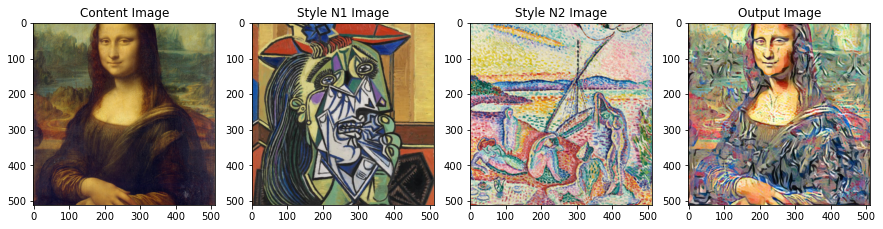

In [44]:
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 4, 1)
imshow(content_img, title='Content Image')

fig.add_subplot(1, 4, 2)
imshow(style_img_1, title='Style N1 Image')

fig.add_subplot(1, 4, 3)
imshow(style_img_2, title='Style N2 Image')

fig.add_subplot(1, 4, 4)
imshow(output, title='Output Image')

С помощью весов style_1_weight=500000, style_2_weight=500000 можно регулировать силу применения (влияния) того или иного стиля.

### 3. Вы разделяете картинку на две части и переносите на них разные стили.

Для этого нужно модифицировать класс StyleLoss и функции get_style_model_and_losses и run_style_transfer.

In [45]:
class StyleLoss2(nn.Module):
    def __init__(self, target_feature, style_num):
        super(StyleLoss2, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = F.mse_loss(self.target, self.target)
        self.style_num = style_num

    def split(self, input):
        # разделим картинку на левую и правую части
        # к кажйдой из которых будет применяться разный стиль
        split_mask = torch.zeros_like(input)
        _, _, _, w = split_mask.size()
        
        if self.style_num == "style_1":
            # применяется от левого края до середины
            split_mask[ :, :, :,  : w//2 ] += 1
            
        if self.style_num == "style_2":
            # применяется от середины до правого края
            split_mask[ :, :, :, w//2 : ] += 1
        
        return input * split_mask    
        
    def forward(self, input):
        splitted = StyleLoss2.split(self, input)
        G = gram_matrix(splitted)
        self.loss = F.mse_loss(G, self.target)
        return input
    

In [46]:
def get_style_model_and_losses_2s_tgz(cnn, normalization_mean, normalization_std,
                                      style_1_img, style_2_img, content_img,
                                      content_layers=content_layers_default,
                                      style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_1_losses = []
        style_2_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                target_1_feature = model(style_1_img).detach()
                style_1_loss = StyleLoss2(target_1_feature, style_num="style_1")
                model.add_module("style_1_loss_{}".format(i), style_1_loss)
                style_1_losses.append(style_1_loss)
                
                target_2_feature = model(style_2_img).detach()
                style_2_loss = StyleLoss2(target_2_feature, style_num="style_2")
                model.add_module("style_2_loss_{}".format(i), style_2_loss)
                style_2_losses.append(style_2_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) -1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss2):
                break

        model = model[:(i + 1)]

        return model, style_1_losses, style_2_losses, content_losses

In [47]:
def run_style_transfer_2s_tgz(cnn, normalization_mean, normalization_std,
                        content_img, style_1_img, style_2_img, input_img, num_steps=500,
                        style_1_weight=50000, style_2_weight=50000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_1_losses, style_2_losses, content_losses = get_style_model_and_losses_2s_tgz(
            cnn, normalization_mean, normalization_std, style_1_img, style_2_img, content_img)
        
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_1_score = 0
                style_2_score = 0
                content_score = 0

                for sl in style_1_losses:
                    style_1_score += sl.loss
                for sl in style_2_losses:
                    style_2_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                # взвешивание ошибки
                style_1_score *= style_1_weight
                style_2_score *= style_2_weight
                content_score *= content_weight

                loss = style_1_score + style_2_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style 1 Loss : {:4f}, Style 2 Loss : {:4f}, Content Loss: {:4f}'.format(
                        style_1_score.item(), style_1_score.item(), content_score.item()))
                    print()

                return style_1_score + style_2_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Штош, обучим модель и посмотрим на результат.

In [48]:
style_1_img = image_loader("images/wave.jpg")
style_2_img = image_loader("images/matisse.jpg")

content_img = image_loader("images/mona_lisa.jpg") 
input_img = content_img.clone()

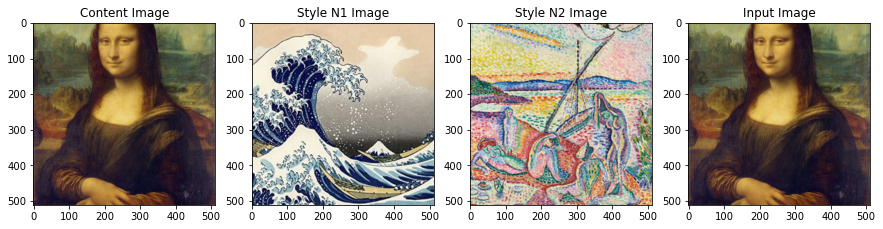

In [49]:
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 4, 1)
imshow(content_img, title='Content Image')

fig.add_subplot(1, 4, 2)
imshow(style_1_img, title='Style N1 Image')

fig.add_subplot(1, 4, 3)
imshow(style_2_img, title='Style N2 Image')

fig.add_subplot(1, 4, 4)
imshow(input_img, title='Input Image')

plt.show()

In [50]:
output = None

In [51]:
tic = time.time()
output = run_style_transfer_2s_tgz(cnn, cnn_normalization_mean, cnn_normalization_std, 
                            content_img, style_img_1, style_img_2, input_img)
toc = time.time()

Building the style transfer model..
Optimizing..


<ipython-input-14-990918138254>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-14-990918138254>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style 1 Loss : 12.209544, Style 2 Loss : 12.209544, Content Loss: 58.516815

run [100]:
Style 1 Loss : 4.573650, Style 2 Loss : 4.573650, Content Loss: 55.213257

run [150]:
Style 1 Loss : 3.158843, Style 2 Loss : 3.158843, Content Loss: 52.878387

run [200]:
Style 1 Loss : 2.833883, Style 2 Loss : 2.833883, Content Loss: 51.704887

run [250]:
Style 1 Loss : 2.636339, Style 2 Loss : 2.636339, Content Loss: 51.469189

run [300]:
Style 1 Loss : 2.451757, Style 2 Loss : 2.451757, Content Loss: 51.417519

run [350]:
Style 1 Loss : 2.360067, Style 2 Loss : 2.360067, Content Loss: 51.337173

run [400]:
Style 1 Loss : 5.210816, Style 2 Loss : 5.210816, Content Loss: 50.014881

run [450]:
Style 1 Loss : 16.016769, Style 2 Loss : 16.016769, Content Loss: 50.165462

run [500]:
Style 1 Loss : 4.521918, Style 2 Loss : 4.521918, Content Loss: 52.292816



Время обучения 280.7995550632477 секунд.


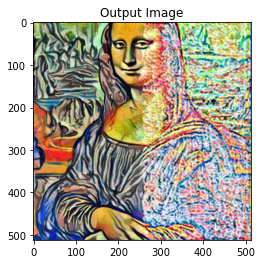

In [52]:
print(f'Время обучения {toc-tic} секунд.')

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

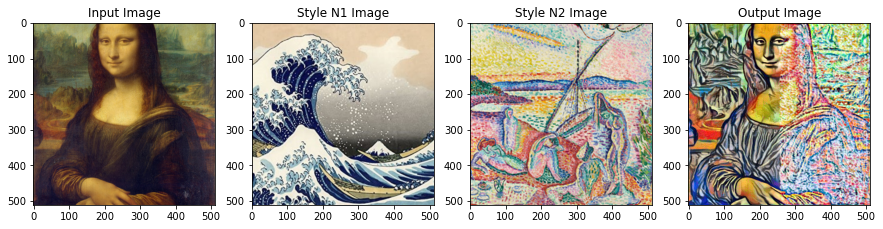

In [53]:
fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 4, 1)
imshow(content_img, title='Input Image')

fig.add_subplot(1, 4, 2)
imshow(style_1_img, title='Style N1 Image')

fig.add_subplot(1, 4, 3)
imshow(style_2_img, title='Style N2 Image')

fig.add_subplot(1, 4, 4)
imshow(output, title='Output Image')

plt.show()

Прекрасно!

Что можно сделать ещё:
 - передавать в функцию обучения пользовательюскую маску в виде бинарной чёрно-белой картинки;
 - сделать предобученную UNet для сегментации чего-то (например, родинок :), после этого можно контент проганять через этот UNet и применять стиль только к отсегментированной части.